#  Air Quality: Design Phase

Welcome to the second lab of this course. Last week, you used exploratory data analysis to gain insight into the Bogotá air quality data obtained from the [RMCAB](http://201.245.192.252:81/home/map). In this notebook, you will work on the next stage of your project: designing your solution. 

Here are the steps you will complete in this notebook: 

1. Import Python packages
2. Load the data
3. Add location (latitude and longitude of sensor stations) to the dataframe
4. Visualize the extent and distribution of missing data
5. Visualize simple methods for estimating missing values
6. Run the nearest neighbor method to establish a baseline
7. Prepare the data to train a neural network model
8. Train and test a neural network model for estimating missing values
9. Visualize the results from your baseline model compared to the neural network
10. Estimate missing sensor measurements across all pollutants 
11. Visualize the results of filling in missing PM2.5 values
12. Optional: write the resulting dataset to a new csv file

## 1. Importar pacotes Python

Execute a próxima célula para importar os pacotes Python que você usará neste exercício de laboratório. Se tudo ocorrer bem, você verá uma mensagem ao final da execução da célula dizendo **"Todos os pacotes importados com sucesso!"**.

Observe a linha `import utils`. Essa linha importa as funções que foram escritas especificamente para este laboratório. Se você quiser ver quais são essas funções, vá em **`Arquivo -> Abrir...`** e abra o arquivo **`utils.py`** para dar uma olhada.

In [1]:
# Import packages
import pandas as pd                                  # package for reading in and manipulating data
from datetime import datetime                        # package for manipulating dates
from sklearn.model_selection import train_test_split # package for splitting data

import utils # utility functions defined for this lab

print('All packages imported successfully!')

/home/polia/repos/air-quality/week3/utils.py:57: SyntaxWarning: invalid escape sequence '\d'
  parts = re.split('[^\d\w]+', coor)
2025-04-22 13:40:39.214898: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 13:40:39.243803: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 13:40:39.545802: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 13:40:39.821852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745340040.042881     760 cuda_dnn.cc:8579] Unable to regi

All packages imported successfully!


## 2. Carregar os dados

Execute a próxima célula para carregar os dados de qualidade do ar de Bogotá. Esta é a mesma etapa que você realizou no laboratório anterior, onde você utiliza o pacote `pandas` para ler o arquivo **csv** contendo os dados em um **dataframe** chamado `raw_data`, depois modifica alguns nomes e formatos de colunas, e por fim exibe as cinco primeiras linhas do dataframe.

In [2]:
# Read in the data
raw_data = pd.read_csv('data/RMCAB_air_quality_sensor_data.csv')

# Modify the DateTime column format
raw_data['DateTime'] = pd.to_datetime(utils.fix_dates(raw_data, 'DateTime'), dayfirst=True)

# Rename columns from Spanish to English
raw_data = raw_data.rename(columns={'OZONO': 'OZONE'})

# print out the number of rows in the dataframe
print(f"The dataset contains {len(raw_data)} entries")

# Print out the first few lines in the dataframe
raw_data.head(5)

The dataset contains 166440 entries


,PM10,PM2.5,NO,NO2,NOX,CO,OZONE,Station,DateTime
0,56.6,32.7,7.504,15.962,23.493,0.44924,2.431,USM,2021-01-01 00:00:00
1,59.3,39.3,16.560,17.866,34.426,0.69832,1.121,USM,2021-01-01 01:00:00
2,96.4,70.8,22.989,17.802,40.791,0.88243,1.172,USM,2021-01-01 02:00:00
3,108.3,81.0,3.704,9.886,13.591,0.29549,6.565,USM,2021-01-01 03:00:00
4,87.7,56.1,2.098,9.272,11.371,0.16621,9.513,USM,2021-01-01 04:00:00


## 3. Adicionar localização (latitude e longitude das estações sensoras) ao dataframe

Execute a próxima célula para ler outro conjunto de dados contendo a localização de cada estação sensora e, em seguida, adicionar essas localizações como novas colunas no seu conjunto de dados de poluição do ar.

**Observação:** os dados utilizados aqui para adicionar a localização de cada estação incluem nomes de colunas em espanhol, como `Sigla` (iniciais), `Latitud` (latitude), `Longitud` (longitude). Na próxima célula, essas colunas também serão renomeadas para seus equivalentes em inglês (usando "station" no lugar de "initials").

In [3]:
# Read in csv file containing location data and format appropriately
stations = pd.read_csv('data/stations_loc.csv')
stations = stations[['Sigla', 'Latitud', 'Longitud']]
# Rename the columns from Spanish to English
stations = stations.rename(columns={'Sigla': 'Station', 'Latitud': 'Latitude', 'Longitud': 'Longitude'})
# Parse the dates
stations['Latitude'] = stations['Latitude'].apply(utils.parse_dms)
stations['Longitude'] = stations['Longitude'].apply(utils.parse_dms)
# Add location data as extra columns to air pollution dataset
raw_data_enriched = pd.merge(raw_data, stations, on='Station', how='inner')
raw_data_enriched.head(5)

,PM10,PM2.5,NO,NO2,NOX,CO,OZONE,Station,DateTime,Latitude,Longitude
0,56.6,32.7,7.504,15.962,23.493,0.44924,2.431,USM,2021-01-01 00:00:00,4.532056,-74.117139
1,59.3,39.3,16.560,17.866,34.426,0.69832,1.121,USM,2021-01-01 01:00:00,4.532056,-74.117139
2,96.4,70.8,22.989,17.802,40.791,0.88243,1.172,USM,2021-01-01 02:00:00,4.532056,-74.117139
3,108.3,81.0,3.704,9.886,13.591,0.29549,6.565,USM,2021-01-01 03:00:00,4.532056,-74.117139
4,87.7,56.1,2.098,9.272,11.371,0.16621,9.513,USM,2021-01-01 04:00:00,4.532056,-74.117139


## 4. Visualizar a extensão e a distribuição dos dados ausentes

### 4.1 Contar valores nulos

Execute a próxima célula para realizar a contagem de valores nulos, assim como você fez no notebook anterior, para relembrar quantos valores ausentes existem em cada coluna do seu conjunto de dados.

In [4]:
# Print out a count of missing data for each column in the dataset
raw_data_enriched.isnull().sum()

PM10         20014
PM2.5        15312
NO           27664
NO2          27662
NOX          27668
CO           31238
OZONE        32132
Station          0
DateTime         0
Latitude         0
Longitude        0
dtype: int64

### 4.2 Visualize dados ausentes em uma série temporal

Execute a célula abaixo para gerar o mesmo gráfico que você viu perto do final do laboratório anterior, ou seja, os valores dos poluentes ao longo do tempo, medidos em uma estação sensora específica. Você pode usar os menus suspensos para escolher diferentes estações e poluentes. Também é possível usar os controles deslizantes para aumentar ou diminuir o zoom em um intervalo específico de datas. Você pode editar os valores de `start_date` e `end_date` e executar a célula de código novamente para começar com um intervalo de datas diferente.

Tente observar diferentes poluentes, bem como diferentes datas e estações sensoras, para investigar o tamanho das lacunas nos dados. Note que, devido à presença de dados ausentes, para algumas combinações de parâmetros pode não haver pontos no gráfico!

In [5]:
# Plot a time series for a particular date range, pollutant, and sensor station
start_date = datetime(2021, 5, 6)
end_date = datetime(2021, 5, 7)
utils.create_time_series_plot(raw_data, start_date, end_date)

interactive(children=(Dropdown(description='Station', options=('USM', 'BOL', 'SUB', 'TUN', 'LFR', 'PTE', 'MAM'…

### 4.3 Visualize a distribuição das lacunas nos dados

Execute a próxima célula para plotar uma contagem do tamanho das lacunas em horas (eixo horizontal) versus o número de pontos de dados ausentes devido a lacunas desse tamanho (eixo vertical). Com esse gráfico, você pode ter uma noção de como lacunas de diferentes tamanhos estão contribuindo para o problema de dados ausentes.

9540
4176


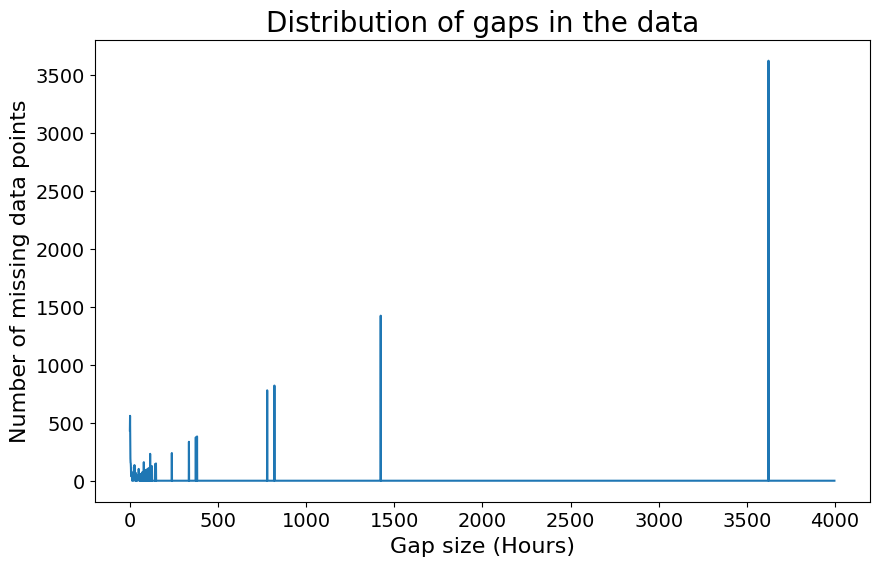

In [6]:
# Plot the distribution of gap sizes in the data
utils.plot_distribution_of_gaps(raw_data, target='NO2')

## 5. Visualizar métodos simples para estimar valores ausentes

Talvez a maneira mais direta de estimar valores ausentes nos seus dados seja simplesmente utilizar o último valor conhecido da série para substituir o valor ausente. Outra opção seria usar uma medição atual da estação mais próxima (método do vizinho mais próximo).

Execute a próxima célula para gerar uma visualização do resultado do preenchimento dos valores ausentes utilizando o último valor conhecido ou o método do vizinho mais próximo.

In [7]:
# Especifique a data para plotar
day = datetime(2021, 5, 6)

# Crie um gráfico para exibir a interpolação linear para um intervalo de horas
utils.visualize_missing_values_estimation(raw_data_enriched, day);

interactive(children=(Dropdown(description='Station', options=('USM', 'BOL', 'SUB', 'TUN', 'LFR', 'PTE', 'MAM'…

## 6. Execute o método do vizinho mais próximo para estabelecer uma linha de base  

Com a próxima célula, você executará seu modelo de vizinho mais próximo em lacunas simuladas nos dados de PM2.5. A distribuição das lacunas que você testará aqui no modelo é simulada para ser semelhante à distribuição nos dados reais. Em princípio, o tamanho das lacunas não deveria importar para este método, mas você simulará a distribuição real para manter a consistência com os dados verdadeiros.  

Você calculará a precisão do modelo de linha de base computando o [Erro Absoluto Médio (MAE)](https://en.wikipedia.org/wiki/Mean_absolute_error). O MAE é simplesmente a diferença média entre a saída do seu modelo e os valores reais (ground truth), neste caso, para PM2.5.  

$$MAE = \frac{1}{n} \sum_{i=1}^{n}{|\rm{real}_i - \rm{modelo}_i|}$$  

Onde "n" é o número de amostras no conjunto de teste.  

Lembre-se de que o MAE é apenas uma das possíveis métricas de erro que você poderia escolher para avaliar seu modelo e, na prática, você pode optar por uma diferente (como o erro quadrático médio, por exemplo), dependendo de como deseja medir o desempenho e do objetivo do seu modelo. Aqui, estamos usando o MAE porque é uma medida simples e intuitiva do desempenho do modelo, em que a estimativa de erro está nas mesmas unidades daquilo que você está tentando estimar — neste caso, os níveis de PM2.5 em microgramas / $\rm{m}^3$.  

Execute a próxima célula para testar o método do vizinho mais próximo e calcular o MAE.

In [8]:
# Create a nearest neighbor model and run it on your test data
regression_scores = {}
regression_scores['baseline_model'] = utils.calculate_mae_for_nearest_station(raw_data_enriched, target='PM2.5')
print(regression_scores['baseline_model'])

{'MAE': 7.922151898734176}


`calculate_mae_for_nearest_station0` calcula o MAE ao prever os valores de uma variável de polunete (target) em um conjunto de teste, usando KNN que é um modelo de vizinho mais próximo, baseado em:
- Horário
- Latitude
- Longitude

Ir para o ``utils.py``

O erro médio absoluto (MAE) é uma forma comum e intuitiva de medir a precisão de suas previsões.
É intuitivo pois, com o erro médio absoluto, suas medições de erro estão nas unidades do que você está tentando estimar, que neste caso são os níveis de PM2,5 em unidades de microgramas por metro cúbico. 

uma forma simples de comparar intuitivamente os resultados de diferentes modelos.
um erro de 8 significa que você está errado em oito em suas estimativas em unidades de medidas do sensor. Que para PM2.5, são microgramas por metro cúbico.

O resultado indica que, em média, o método do vizinho mias próximo retorna um valor que está errado em 8 microgramas/m³ em relação à medição real.
Com um erro médio de oito, estamos trabalhando com uma margem de erro que pode facilmente estar acima ou abaixo do nível recomendado. Essa estimativa de erro agora pode servir como base para o quão bem você pode se sair sem implementar nada mais complicado com a IA.

## 7. Prepare os dados para treinar um modelo de rede neural  

Agora que você estabeleceu uma linha de base, preparará seu conjunto de dados para treinar e testar um modelo de rede neural capaz de estimar valores faltantes de PM2.5.  

### 7.1. Remova valores ausentes e adicione colunas para uso posterior com o modelo de rede neural  
Para isso, você primeiro removerá todas as linhas com valores ausentes do conjunto de dados original e, em seguida, simulará lacunas de diferentes tamanhos para testar o modelo. Antes de remover as linhas com valores faltantes, você também adicionará algumas colunas extras ao conjunto de dados para preparar o treinamento da rede neural. Essas novas colunas incluem o dia da semana (`day_week`) e a hora do dia (`hour`). A linha de código que define a variável `one_hot` está convertendo o ID da estação em uma representação numérica para indicar de qual estação cada medição foi obtida.

In [9]:
# Define the variable you want to predict
target = 'PM2.5'

# Create new columns for day of week and hour of day
raw_data_for_imputing = raw_data_enriched.copy()
raw_data_for_imputing['day_week'] = pd.DatetimeIndex(raw_data_for_imputing['DateTime']).weekday
raw_data_for_imputing['hour'] = pd.DatetimeIndex(raw_data_for_imputing['DateTime']).hour

# Create a numerical representation of station ID and add as extra columns to the dataframe
one_hot = pd.get_dummies(raw_data_for_imputing.Station, prefix='Station')
raw_data_for_imputing = raw_data_for_imputing.join(one_hot)

# Make a copy of the dataframe before dropping rows with missing values
data_no_missing = raw_data_for_imputing.copy()  

# Drop all rows containing missing values
data_no_missing.dropna(inplace=True)

# Print out the number of missing values in the PM2.5 column as a check (should print 0)
null_remaining = data_no_missing[target].isnull().sum()
if null_remaining == 0: 
    print('missing values removed and data prepared successfully!')

missing values removed and data prepared successfully!


### 7.2 Dividir os dados em conjuntos de treinamento e teste
Para comparar adequadamente seu modelo de linha de base com o modelo de rede neural, é essencial executar os testes no mesmo subconjunto de dados. Nesta etapa, você separará um conjunto de teste que será usado tanto para avaliar o modelo de referência (baseline) quanto para compará-lo com o desempenho da rede neural.

<img src="img/split_data.png" alt="split_data" width="400"/>

<center><b>Figure 1:</b> Splitting data into training and testing sets </center>

Run the next cell to separate out 20% of your data for testing.

In [10]:
train_data, test_data = train_test_split(data_no_missing, test_size=0.20, random_state=57)

print(f'Train dataset size: {train_data.shape}')
print(f'Test dataset size: {test_data.shape}')

Train dataset size: (73309, 32)
Test dataset size: (18328, 32)




    
</details>



## 8. Treine and teste um modelo de rede neural para estimar dados ausentes.

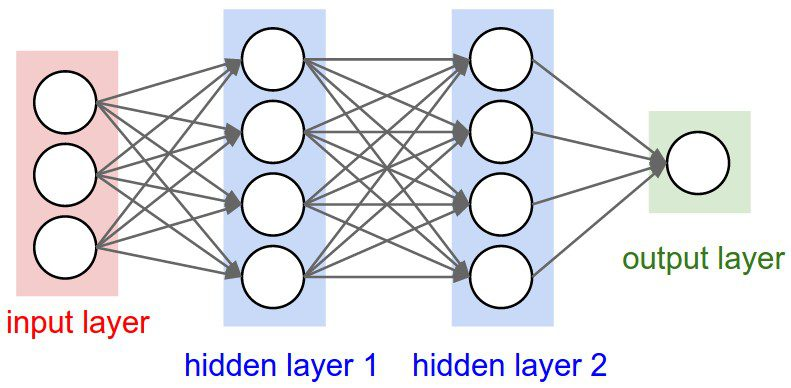


Execute a próxima célula para treinar e testar um modelo de rede neural para estimar valores faltantes de PM2.5. Neste caso, você precisará treinar a rede neural para aprender como os valores de PM2.5 se relacionam com os valores dos outros poluentes, bem como com horário do dia, dia da semana e localização da estação. Observe que a rede neural que você treinará será muito maior do que a mostrada na figura, pois contém 64 e 32 unidades nas duas camadas ocultas.

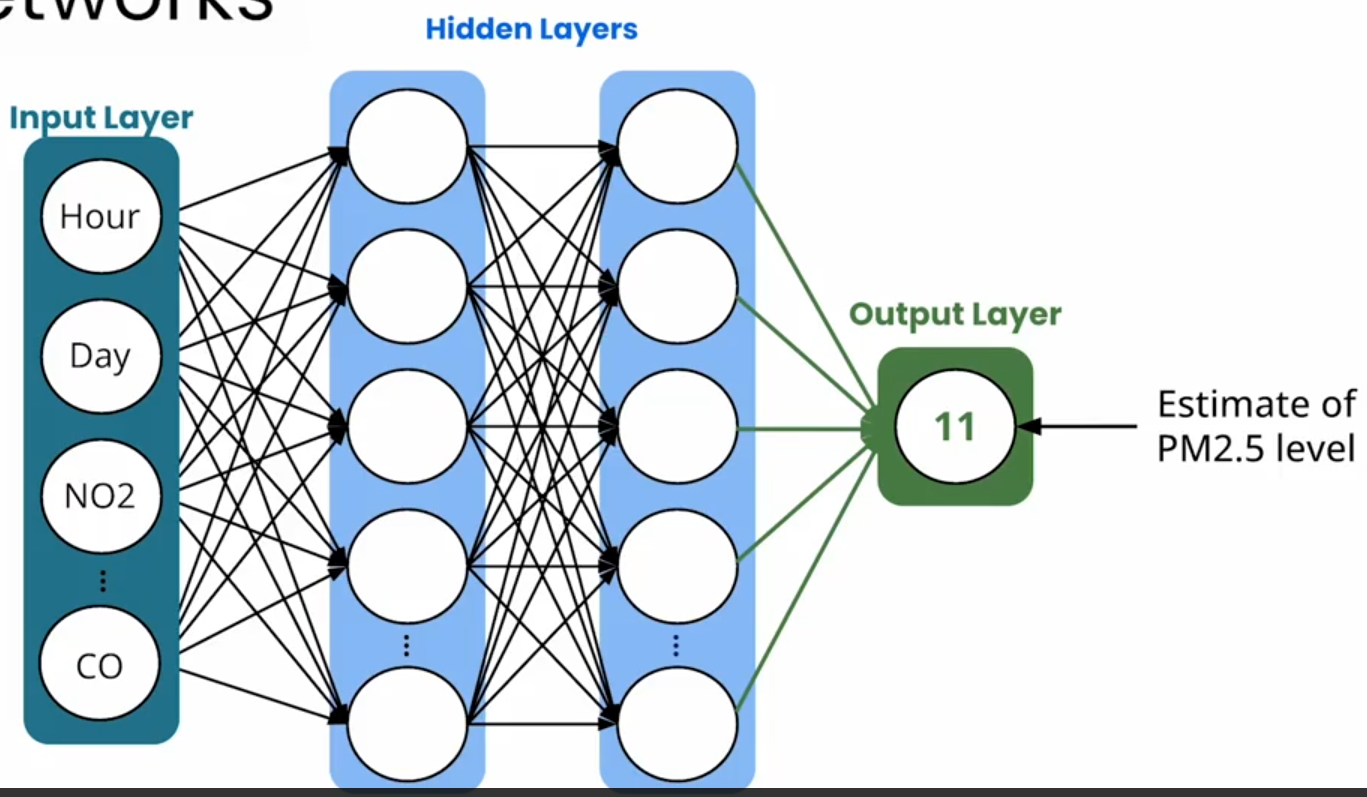

In [11]:
# Defina os recursos nos quais você baseará suas previsões
pollutants_list = ['PM10','PM2.5','NO','NO2','NOX','CO','OZONE']
pollutants_except_target = [i for i in pollutants_list if i != target]
feature_names = ['day_week', 'hour'] + list(one_hot.columns) + pollutants_except_target

# Define the neural network model architecture
model = utils.build_keras_model(input_size=len(feature_names))

# Train and test the model
model, scaler, mae = utils.train_and_test_model(feature_names, target, train_data, test_data, model)
regression_scores['neural_network_model'] = mae

/home/polia/Venvs/aq/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-22 13:43:21.387079: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 47.9175 - mae: 4.9215
Epoch 2/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 35.1448 - mae: 4.3431
Epoch 3/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 33.8045 - mae: 4.2594
Epoch 4/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 33.1178 - mae: 4.2065
Epoch 5/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 32.4220 - mae: 4.1798
Epoch 6/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 32.5098 - mae: 4.1553
Epoch 7/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 32.1879 - mae: 4.1331
Epoch 8/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 32.2066 - mae: 4.1279
Epoch 9/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 32.7100 - mae: 4.1293
Epoch 10/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 31.7077 - mae: 4.1256
Epoch 11/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 31.4783 - mae: 4.0822
Epoch 12/100
1146/1146 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss:

Compare the **MAE** obtained using the 2 methods. This value has been obtained using the same test set so its comparable.

In [12]:
# Print out the MAE result
for model_name, model_score in regression_scores.items():
    print(model_name, ' : ', model_score)

baseline_model  :  {'MAE': 7.922151898734176}
neural_network_model  :  {'MAE': 4.136250658552493}


## 9. Visualize os resultados do modelo de linha de base comparados com os da rede neural  

Execute a próxima célula para visualizar os resultados do modelo de linha de base e do modelo de rede neural. Use os menus suspensos para selecionar entre diferentes localizações de estações e diferentes tamanhos de "janela" (lacunas em horas). Utilize o controle deslizante para escolher o índice inicial da janela que deseja analisar. Você também pode alterar os valores de `start_date` e `end_date` para outras datas em 2021.  

In [13]:
start_date = datetime(2021, 2, 1)
end_date = datetime(2021, 2, 3)

utils.create_plot_with_preditions(data_no_missing, model, scaler, feature_names, target,  start_date, end_date)

interactive(children=(Dropdown(description='Station', options=('USM', 'BOL', 'SUB', 'TUN', 'LFR', 'PTE', 'MAM'…

## 10. Estimar medições faltantes de sensores para todos os poluentes.

Com a primeira linha de código abaixo, você estimará os valores faltantes para todos os poluentes não-PM2.5 usando o método dos vizinhos mais próximos. Com a segunda linha, você usará sua rede neural para estimar os valores faltantes de PM2.5. A última linha simplesmente exibe novamente o número de valores faltantes em cada coluna, que deve ser zero se tudo ocorreu corretamente.

In [14]:
# Estimate non-PM2.5 missing values with the nearest neighbor method
imputed_with_baseline_model = utils.impute_nontarget_missing_values_interpolate(raw_data_for_imputing, feature_names, target)
# Estimate missing PM2.5 values with 
data_with_imputed = utils.impute_target_missing_values_neural_network(raw_data_for_imputing, model, scaler, imputed_with_baseline_model, target)
# Print out a count of missing data for each column in the dataset with imputed values
data_with_imputed[pollutants_list].isnull().sum()

479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


PM10     0
PM2.5    0
NO       0
NO2      0
NOX      0
CO       0
OZONE    0
dtype: int64

In [15]:
# Print out a sample of the dataframe
data_with_imputed.sample(25)

,DateTime,Station,Latitude,Longitude,PM2.5,PM10,NO,NO2,NOX,CO,OZONE,PM2.5_imputed_flag,PM10_imputed_flag,NO_imputed_flag,NO2_imputed_flag,NOX_imputed_flag,CO_imputed_flag,OZONE_imputed_flag
35397,2021-01-15 21:00:00,LFR,4.690700,-74.082483,27.000000,49.500000,11.812000,33.874000,45.691000,0.727980,1.143000,None,None,None,None,None,None,None
83641,2021-07-20 01:00:00,SCR,4.572553,-74.083814,0.000000,7.000000,0.384000,2.995000,3.379000,0.130920,15.500000,None,None,None,None,None,None,None
52813,2021-01-11 13:00:00,MAM,4.625486,-74.066981,1.000000,6.800000,1.889703,8.094542,9.984456,0.272000,26.058000,None,None,interpolated,interpolated,interpolated,None,None
95453,2021-11-24 05:00:00,FTB,4.678242,-74.143819,21.000000,32.600000,43.876000,21.266000,65.133000,0.794120,1.300000,None,None,None,None,None,None,None
142069,2021-03-21 13:00:00,MOV2,4.668000,-74.148500,104.000366,48.097012,12.531479,16.784865,29.316343,0.502401,3.879839,neural network,interpolated,interpolated,interpolated,interpolated,interpolated,interpolated
90745,2021-05-12 01:00:00,FTB,4.678242,-74.143819,6.830112,7.218919,6.963432,4.402892,11.381622,0.517745,13.939324,neural network,interpolated,interpolated,interpolated,interpolated,interpolated,interpolated
67526,2021-09-16 14:00:00,CBV,4.577806,-74.166278,16.900000,22.900000,2.346000,5.179000,7.525000,0.267690,15.574000,None,None,None,None,None,None,None
46653,2021-04-29 21:00:00,PTE,4.631767,-74.117483,11.000000,14.500000,29.365000,16.153000,45.518000,0.935040,0.091000,None,None,None,None,None,None,None
82536,2021-06-04 00:00:00,SCR,4.572553,-74.083814,4.000000,5.000000,2.995000,6.377000,9.371000,0.254900,5.219000,None,None,None,None,None,None,None
104606,2021-12-10 14:00:00,JAZ,4.608500,-74.114944,15.600000,37.600000,7.855000,15.760000,23.615000,0.499420,18.383714,None,None,None,None,None,None,interpolated


Você pode ver que as colunas de sinalização (**flag**) incluem diferentes valores: `None` onde há dados originais, `'neural network'` onde os valores foram imputados com a rede neural e `'interpolated'` onde os valores foram interpolados.

## 11. Visualizar os resultados do preenchimento dos valores ausentes de PM2.5

Você pode usar as colunas de sinalização que registrou acima para diferenciar os dados originais dos dados estimados, e pode visualizar isso executando a célula abaixo.

In [16]:
# Define a start and end date and visualize missing values that have been imputed
start_date = datetime(2021, 3, 1)
end_date = datetime(2021, 4, 30)
utils.create_time_series_plot(data_with_imputed, start_date, end_date)

interactive(children=(Dropdown(description='Station', options=('USM', 'BOL', 'SUB', 'TUN', 'LFR', 'PTE', 'MAM'…

## 12. Opcional: salvar o conjunto de dados resultante em um novo arquivo csv

Por fim, você pode salvar os dados em um novo arquivo **csv** para utilizar na próxima etapa do projeto. Neste caso, os dados serão fornecidos para você no próximo laboratório, então não é necessário salvá-los aqui — mas incluímos a linha de código abaixo para mostrar como você pode salvar os dados em um arquivo. Se você remover o comentário da linha de código abaixo (tirar o `#`), poderá executar a célula e depois clicar no ícone do Jupyter acima para ver o novo arquivo **csv** na sua pasta, junto com o restante do conteúdo do laboratório.

In [17]:
# data_with_imputed.to_csv('full_data_with_imputed_values.csv')

## **Congratulations on finishing this lab!**

**Keep up the good work :)**